In [1]:
# Blended 3

import warnings
import pandas as pd
import numpy as np
from sklearn.metrics import ConfusionMatrixDisplay, classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn import tree

In [2]:

data = pd.read_csv('../datasets/mod_03_topic_05_weather_data.csv.gz')
print(data.shape)

(145460, 23)


In [3]:

print(data.dtypes)

Date              object
Location          object
MinTemp          float64
MaxTemp          float64
Rainfall         float64
Evaporation      float64
Sunshine         float64
WindGustDir       object
WindGustSpeed    float64
WindDir9am        object
WindDir3pm        object
WindSpeed9am     float64
WindSpeed3pm     float64
Humidity9am      float64
Humidity3pm      float64
Pressure9am      float64
Pressure3pm      float64
Cloud9am         float64
Cloud3pm         float64
Temp9am          float64
Temp3pm          float64
RainToday         object
RainTomorrow      object
dtype: object


In [4]:

print(data.isna().mean().sort_values(ascending=False))

Sunshine         0.480098
Evaporation      0.431665
Cloud3pm         0.408071
Cloud9am         0.384216
Pressure9am      0.103568
Pressure3pm      0.103314
WindDir9am       0.072639
WindGustDir      0.070989
WindGustSpeed    0.070555
Humidity3pm      0.030984
WindDir3pm       0.029066
Temp3pm          0.024811
RainTomorrow     0.022460
Rainfall         0.022419
RainToday        0.022419
WindSpeed3pm     0.021050
Humidity9am      0.018246
Temp9am          0.012148
WindSpeed9am     0.012148
MinTemp          0.010209
MaxTemp          0.008669
Location         0.000000
Date             0.000000
dtype: float64


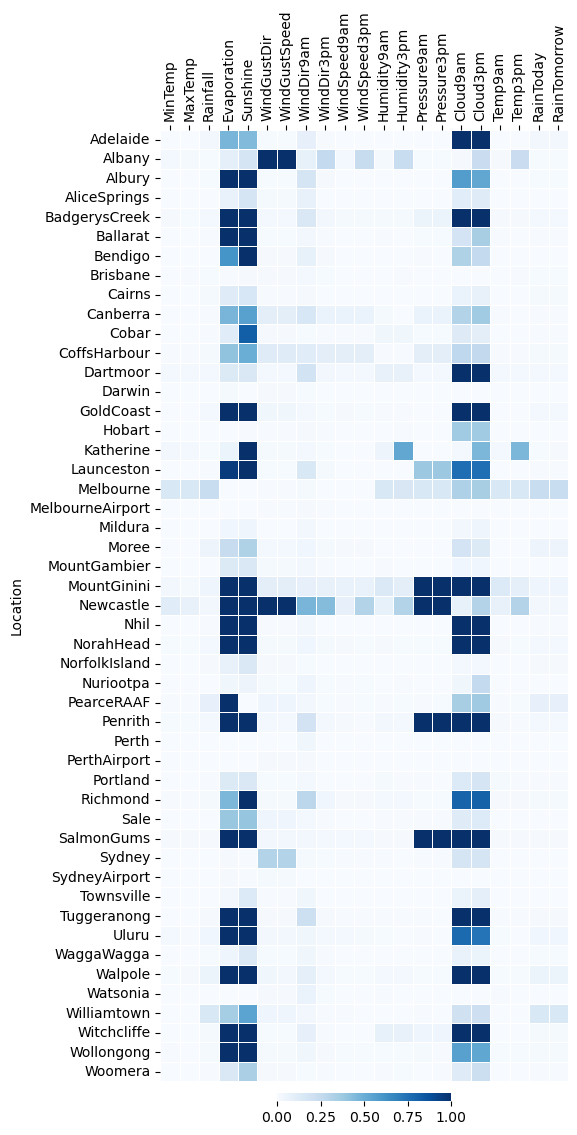

In [5]:

with warnings.catch_warnings():
    warnings.simplefilter('ignore')
    tmp = (data
           .groupby('Location')
           .apply(lambda x:
                  x.drop(['Location', 'Date'], axis=1)
                  .isna()
                  .mean()))

plt.figure(figsize=(9, 15), dpi=100)

ax = sns.heatmap(tmp,
                 cmap='Blues',
                 linewidth=0.5,
                 square=True,
                 cbar_kws=dict(
                     location="bottom",
                     pad=0.01,
                     shrink=0.25))

ax.xaxis.tick_top()
ax.tick_params(axis='x', labelrotation=90)

plt.show()

In [6]:

data = data[data.columns[data.isna().mean().lt(0.35)]]

data = data.dropna(subset='RainTomorrow')

In [7]:

data_num = data.select_dtypes(include=np.number)
data_cat = data.select_dtypes(include='object')

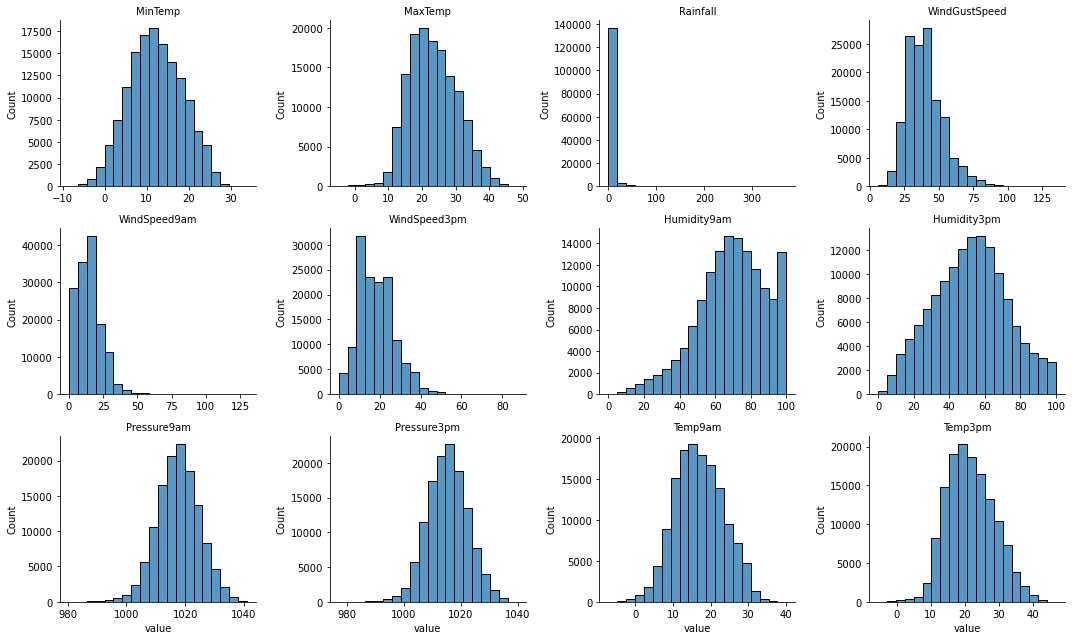

In [8]:

melted = data_num.melt()

g = sns.FacetGrid(melted,
                  col='variable',
                  col_wrap=4,
                  sharex=False,
                  sharey=False,
                  aspect=1.25)

g.map(sns.histplot, 'value', bins=20)

g.set_titles(col_template='{col_name}')

g.tight_layout()

plt.show()

In [9]:

print(data_cat.nunique())

Date            3436
Location          49
WindGustDir       16
WindDir9am        16
WindDir3pm        16
RainToday          2
RainTomorrow       2
dtype: int64


In [10]:

data_cat.apply(lambda x: x.unique()[:5])

Date            [2008-12-01, 2008-12-02, 2008-12-03, 2008-12-0...
Location        [Albury, BadgerysCreek, Cobar, CoffsHarbour, M...
WindGustDir                                [W, WNW, WSW, NE, NNW]
WindDir9am                                  [W, NNW, SE, ENE, SW]
WindDir3pm                                   [WNW, WSW, E, NW, W]
RainToday                                          [No, Yes, nan]
RainTomorrow                                            [No, Yes]
dtype: object

In [11]:

data_cat['Date'] = pd.to_datetime(data_cat['Date'])

data_cat['Year'] = data_cat['Date'].dt.year.astype(str)
data_cat['Month'] = data_cat['Date'].dt.month.astype(str)
    
data_cat = data_cat.drop('Date', axis=1)

data_cat[['Year', 'Month']].head()

,Year,Month
0,2008,12
1,2008,12
2,2008,12
3,2008,12
4,2008,12


In [12]:

X_train_num, X_test_num, X_train_cat, X_test_cat, y_train, y_test = (
    train_test_split(
        data_num,
        data_cat.drop('RainTomorrow', axis=1),
        data['RainTomorrow'],
        test_size=0.3,
        random_state=99))

In [13]:

num_imputer = SimpleImputer(strategy='mean').set_output(transform='pandas')
X_train_num = num_imputer.fit_transform(X_train_num)
X_test_num = num_imputer.transform(X_test_num)


In [14]:

cat_imputer = SimpleImputer(
    strategy='most_frequent').set_output(transform='pandas')
X_train_cat = cat_imputer.fit_transform(X_train_cat)
X_test_cat = cat_imputer.transform(X_test_cat)


In [15]:

scaler = StandardScaler().set_output(transform='pandas')

X_train_num = scaler.fit_transform(X_train_num)
X_test_num = scaler.transform(X_test_num)

In [16]:

encoder = (OneHotEncoder(drop='if_binary',
                          sparse_output=False)
            .set_output(transform='pandas'))

X_train_cat = encoder.fit_transform(X_train_cat)
X_test_cat = encoder.transform(X_test_cat)

X_train_cat.shape

(99535, 121)

In [17]:

X_train = pd.concat([X_train_num, X_train_cat], axis=1)
X_test = pd.concat([X_test_num, X_test_cat], axis=1)

X_train.shape

(99535, 133)

In [18]:

print(y_train.value_counts(normalize=True))

RainTomorrow
No     0.776089
Yes    0.223911
Name: proportion, dtype: float64


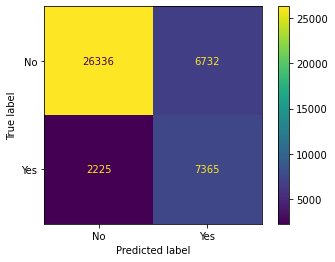

              precision    recall  f1-score   support

          No       0.92      0.80      0.85     33068
         Yes       0.52      0.77      0.62      9590

    accuracy                           0.79     42658
   macro avg       0.72      0.78      0.74     42658
weighted avg       0.83      0.79      0.80     42658



In [19]:

clf = (LogisticRegression(random_state=99, 
                          class_weight='balanced')
       .fit(X_train, y_train))

pred = clf.predict(X_test)

ConfusionMatrixDisplay.from_predictions(y_test, pred)

plt.show()

print(classification_report(y_test, pred))

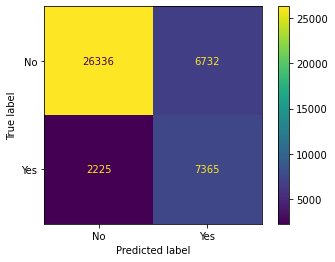

              precision    recall  f1-score   support

          No       0.92      0.80      0.85     33068
         Yes       0.52      0.77      0.62      9590

    accuracy                           0.79     42658
   macro avg       0.72      0.78      0.74     42658
weighted avg       0.83      0.79      0.80     42658



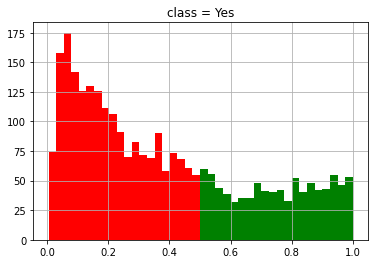

In [20]:

# Pred proba LR

threshold = 0.5

y_pred_proba = pd.Series(clf.predict_proba(X_test)[:,1])
y_pred = y_pred_proba.apply(lambda x: 'Yes' if x > threshold else 'No')

ConfusionMatrixDisplay.from_predictions(y_test, y_pred)

plt.show()

print(classification_report(y_test, y_pred))

df_proba = pd.DataFrame()
df_proba['y_pred_proba'] = y_pred_proba
df_proba['y_test'] = y_test

target_class = 'Yes'

df_proba[
    (df_proba['y_pred_proba'] < threshold) &
    (df_proba['y_test'] == target_class)
]['y_pred_proba'].hist(bins=20, color='red');

df_proba[
    (df_proba['y_pred_proba'] >= threshold) &
    (df_proba['y_test'] == target_class)
]['y_pred_proba'].hist(bins=20, color='green');

plt.title(f'class = {target_class}');


In [21]:
# %%
# %%
# %%
# %%
# %%

# Forest

X_train_num, X_test_num, X_train_cat, X_test_cat, y_train, y_test = (
    train_test_split(
        data_num,
        data_cat.drop('RainTomorrow', axis=1),
        data['RainTomorrow'],
        test_size=0.2,
        random_state=99))

In [22]:

num_imputer = SimpleImputer().set_output(transform='pandas')
X_train_num = num_imputer.fit_transform(X_train_num)
X_test_num = num_imputer.transform(X_test_num)


In [23]:

cat_imputer = SimpleImputer(
    strategy='most_frequent').set_output(transform='pandas')
X_train_cat = cat_imputer.fit_transform(X_train_cat)
X_test_cat = cat_imputer.transform(X_test_cat)

In [24]:

encoder = (OneHotEncoder(drop='if_binary',
                          sparse_output=False)
            .set_output(transform='pandas'))

X_train_cat = encoder.fit_transform(X_train_cat)
X_test_cat = encoder.transform(X_test_cat)

X_train_cat.shape

(113754, 121)

In [25]:

X_train = pd.concat([X_train_num, X_train_cat], axis=1)
X_test = pd.concat([X_test_num, X_test_cat], axis=1)

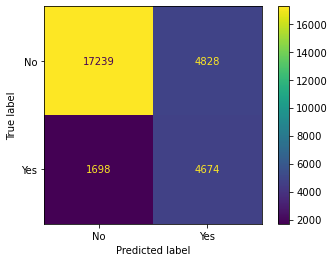

              precision    recall  f1-score   support

          No       0.91      0.78      0.84     22067
         Yes       0.49      0.73      0.59      6372

    accuracy                           0.77     28439
   macro avg       0.70      0.76      0.71     28439
weighted avg       0.82      0.77      0.78     28439



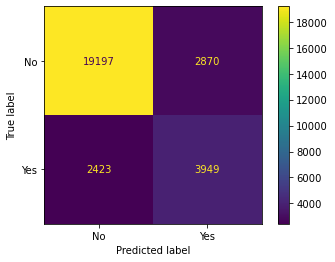

              precision    recall  f1-score   support

          No       0.89      0.87      0.88     22067
         Yes       0.58      0.62      0.60      6372

    accuracy                           0.81     28439
   macro avg       0.73      0.74      0.74     28439
weighted avg       0.82      0.81      0.82     28439



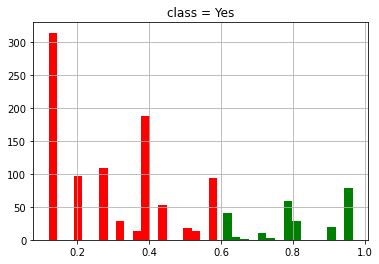

In [26]:

dtc = (tree.DecisionTreeClassifier(random_state=99, 
                          class_weight='balanced',
                          max_depth=5)
       .fit(X_train, y_train))

pred = dtc.predict(X_test)

ConfusionMatrixDisplay.from_predictions(y_test, pred)

plt.show()

print(classification_report(y_test, pred))

# %% 

# Pred proba DTC

threshold = 0.6

y_pred_proba = pd.Series(dtc.predict_proba(X_test)[:,1])
y_pred = y_pred_proba.apply(lambda x: 'Yes' if x > threshold else 'No')

ConfusionMatrixDisplay.from_predictions(y_test, y_pred)

plt.show()

print(classification_report(y_test, y_pred))

df_proba = pd.DataFrame()
df_proba['y_pred_proba'] = y_pred_proba
df_proba['y_test'] = y_test

target_class = 'Yes'

df_proba[
    (df_proba['y_pred_proba'] < threshold) &
    (df_proba['y_test'] == target_class)
]['y_pred_proba'].hist(bins=20, color='red');

df_proba[
    (df_proba['y_pred_proba'] >= threshold) &
    (df_proba['y_test'] == target_class)
]['y_pred_proba'].hist(bins=15, color='green');

plt.title(f'class = {target_class}');